## to install pytorch

In [1]:
# import sys
# !{sys.executable} -m pip install torch==1.2.0+cpu torchvision==0.4.0+cpu -f https://download.pytorch.org/whl/torch_stable.html


## Data preprocessing

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import time


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=False, num_workers=1)  


validation_data_path = './horse-or-human/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=3, shuffle=False, num_workers=1)
TTOTAL = 1027
VTOTAL = 256
train_data = np.zeros((TTOTAL,10000))
val_data = np.zeros((VTOTAL,10000))
train_lab = np.zeros((TTOTAL,1))
val_lab = np.zeros((VTOTAL,1))


NUM_EPOCH = 1
index = 0
for epoch in range(0, NUM_EPOCH):
    # load training images of the batch size for every iteration
    for i, data in enumerate(trainloader):

        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs)
        #print(np.concatenate((temp[:1, :],labels[0]),axis = 0))

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        lab_temp = labels.numpy() 
        for num in range(0, len(inputs)):
            temp = inputs.view(len(inputs), -1)
            temp = temp[num:num+1, :].numpy()
            train_data[index] = temp[0]
            train_lab[index] = lab_temp[num]
            index += 1                                 #make torch to numpy and save it with vectorize (train data)


    index = 0

    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
        #print(inputs)

        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
        #print(labels)    
        
        lab_temp = labels.numpy()
        for num in range(0, len(inputs)):
                temp = inputs.view(len(inputs), -1)
                temp = temp[num:num+1, :].numpy()
                val_data[index] = temp[0]
                val_lab[index] = lab_temp[num]
                index += 1                             #make torch to numpy and save it with vectorize (validation data)

train_data = np.concatenate((train_data, np.ones((TTOTAL,1))), axis = 1)
val_data = np.concatenate((val_data, np.ones((VTOTAL,1))), axis = 1)           #attach bias to data set


## methods for iteration

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np. exp(-z)) / (np.exp(z) + np.exp(-z))

def ReLU(z):
    return np.maximum(0, z)

def L_ReLU(z, alpha):
    return np.maximum(alpha * z, z)
    
def d_R(z):
    dz = np.ones_like(z)
    dz[z <= 0] = 0
    return dz

def d_LR(z, alpha):
    dz = np.ones_like(z)
    dz[z <= 0] = alpha
    return dz

def crossEntropy(l,y):
    return -((l * np.log(y)) + ((1 - l) * np.log(1 - y)))      

def loss(l,y, total):
    return (1 / total) * (np.sum(crossEntropy(l,y)))

def accuracy(l,y, total):
    cor = 0
    for num in range(total):
        if (y[num] > 0.5 and l[num] == 1):
            cor = cor + 1
        elif (y[num] <= 0.5 and l[num] == 0):
            cor = cor + 1
    return cor / total

## make iteration with Leaky ReLU

In [ ]:
H1 = 110
H2 = 37

u = np.random.randn(H1, 10001)/np.sqrt(10001/2)
v = np.random.randn(H2, H1)/np.sqrt(H1/2)
w = np.random.randn(1, H2)/np.sqrt(H2/2)

alpha = 0.01
learning_rate = 0.015
train_loss_LR = []
val_loss_LR = []
train_acc_LR = []
val_acc_LR = []
last = 0
end = 0
train_loss_best = 100
val_loss_best = 100
train_acc_best = 0
val_acc_best = 0

while True:
    
    # forward propagation 
    a = np.dot(u, train_data.T)
    y = L_ReLU(a, alpha)
    b = np.dot(v, y)
    z = L_ReLU(b, alpha)
    c = np.dot(w, z)
    h = sigmoid(c)
    h_v = sigmoid(np.dot(w,L_ReLU(np.dot(v,L_ReLU(np.dot(u, val_data.T), alpha)),alpha)))
    
    # back propagation 
    temp = h.T - train_lab
    w_temp = np.dot(temp.T, z.T) * (1 / TTOTAL)

    temp = np.dot(temp, w) * (d_LR(z, alpha)).T
    v_temp = (np.dot(temp.T, y.T) * (1 / TTOTAL))

    u_temp = (np.dot((np.dot(temp, v) * (d_LR(y, alpha)).T).T, train_data)) * (1 / TTOTAL)
    
    w = w - (learning_rate * w_temp)
    v = v - (learning_rate * v_temp)
    u = u - (learning_rate * u_temp)
    
    t1 = loss(train_lab, h.T, TTOTAL)
    t2 = loss(val_lab, h_v.T, VTOTAL)
    
    # get loss and accuracy
    train_loss_LR.append(t1)
    val_loss_LR.append(t2)
    
    if (t1 < train_loss_best): train_loss_best = t1
    if (t2 < val_loss_best): val_loss_best = t2
    
    t1 = accuracy(train_lab, h.T, TTOTAL)
    t2 = accuracy(val_lab, h_v.T, VTOTAL)
    
    train_acc_LR.append(t1)
    val_acc_LR.append(t2)
    
    if (t1 > train_acc_best): train_acc_best = t1
    if (t2 > val_acc_best): val_acc_best = t2
    
    
    if (abs(train_loss_LR[end]-last) < 10e-6):
        break
    else :
        last = train_loss_LR[end]
        end = end + 1
        continue

## Final loss and accuracy 

In [13]:
print("  final      |    loss    |   accuracy   | ")
print("------------------------------------------ ")
print("  training   |    %.3f   |    %.3f     | " %(train_loss_LR[-1],train_acc_LR[-1]))
print("------------------------------------------ ")
print(" validation  |    %.3f   |    %.3f     | " %(val_loss_LR[-1],val_acc_LR[-1]))
print("------------------------------------------ ")
print("  best       |    loss    |   accuracy   | ")
print("------------------------------------------ ")
print("  training   |    %.3f   |    %.3f     | " %(train_loss_best, train_acc_best))
print("------------------------------------------ ")
print(" validation  |    %.3f   |    %.3f     | " %(val_loss_best,val_acc_best))
print("------------------------------------------ ")




  final      |    loss    |   accuracy   | 
------------------------------------------ 
  training   |    0.307   |    0.877     | 
------------------------------------------ 
 validation  |    0.469   |    0.805     | 
------------------------------------------ 
  best       |    loss    |   accuracy   | 
------------------------------------------ 
  training   |    0.307   |    0.877     | 
------------------------------------------ 
 validation  |    0.321   |    0.918     | 
------------------------------------------ 


## plot loss, accuracy, and calculation time

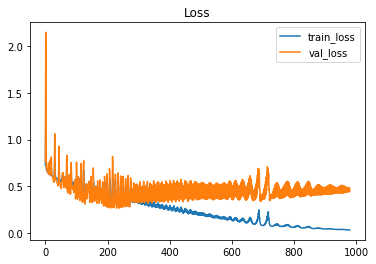

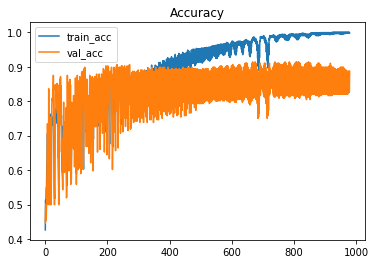

In [4]:
plt.title("Loss")
plt.plot(train_loss_LR)
plt.plot(val_loss_LR)
plt.legend(['train_loss','val_loss'])
plt.show()

plt.figure()
plt.plot(train_acc_LR)
plt.plot(val_acc_LR)
plt.title("Accuracy")
plt.legend(['train_acc','val_acc'])
plt.show()